In [1]:
# pylint: disable=line-too-long
from qiskit.algorithms import VQE
from qiskit_nature.algorithms import (GroundStateEigensolver,
                                      NumPyMinimumEigensolverFactory)
from qiskit_nature.drivers import Molecule, UnitsType
from qiskit_nature.drivers.second_quantization import PySCFDriver, ElectronicStructureMoleculeDriver, ElectronicStructureDriverType
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper
# pylint: enable=line-too-long

import matplotlib.pyplot as plt
import numpy as np
from qiskit_nature.circuit.library import UCCSD, HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP
from qiskit.opflow import TwoQubitReduction
from qiskit import BasicAer, Aer
from qiskit.utils import QuantumInstance
from qiskit.utils.mitigation import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel

In [2]:

def get_qubit_op(dist):
    # Define Molecule
    molecule = Molecule(
        # Coordinates in Angstrom
        geometry=[
            ["Li", [0.0, 0.0, 0.0]],
            ["H", [dist, 0.0, 0.0]]
        ],
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )

    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type=ElectronicStructureDriverType.PYSCF)

    # Get properties
    properties = driver.run()
    num_particles = (properties
                        .get_property("ParticleNumber")
                        .num_particles)
    num_spin_orbitals = int(properties
                            .get_property("ParticleNumber")
                            .num_spin_orbitals)

    # Define Problem, Use freeze core approximation, remove orbitals.
    problem = ElectronicStructureProblem(
        driver,
        [FreezeCoreTransformer(freeze_core=True,
                               remove_orbitals=[-3,-2])])

    second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles
    #print(second_q_ops)
    # Get Hamiltonian
    mapper = ParityMapper()  # Set Mapper
    hamiltonian = second_q_ops[0]  # Set Hamiltonian
    # Do two qubit reduction
    converter = QubitConverter(mapper,two_qubit_reduction=True)
    reducer = TwoQubitReduction(num_particles)
    qubit_op = converter.convert(hamiltonian)
    qubit_op = reducer.convert(qubit_op)

    return qubit_op, num_particles, num_spin_orbitals, problem, converter

In [3]:
def exact_solver(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

backend = BasicAer.get_backend("statevector_simulator")
distances = np.arange(0.5, 4.0, 0.2)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=5)

# pylint: disable=undefined-loop-variable
for dist in distances:
    (qubit_op, num_particles, num_spin_orbitals,
                             problem, converter) = get_qubit_op(dist)
    result = exact_solver(problem,converter)
    exact_energies.append(result.total_energies[0].real)
    init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
    var_form = UCCSD(converter,
                     num_particles,
                     num_spin_orbitals,
                     initial_state=init_state)
    vqe = VQE(var_form, optimizer, quantum_instance=backend)
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies.append(vqe_result)
    print(f"Interatomic Distance: {np.round(dist, 2)}",
          f"VQE Result: {vqe_result:.5f}",
          f"Exact Energy: {exact_energies[-1]:.5f}")

print("All energies have been calculated")

KeyboardInterrupt: 

In [5]:
def get_qubit_op_h2(dist):
    # Define Molecule
    molecule = Molecule(
        # Coordinates in Angstrom
        geometry=[
            ["H", [0.0, 0.0, 0.0]],
            ["H", [0.0, 0.0, dist]]
        ],
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )

    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type=ElectronicStructureDriverType.PYSCF)

    # Get properties
    properties = driver.run()
    num_particles = (properties
                        .get_property("ParticleNumber")
                        .num_particles)
    num_spin_orbitals = int(properties
                            .get_property("ParticleNumber")
                            .num_spin_orbitals)

    # Define Problem, Use freeze core approximation, remove orbitals.
    problem = ElectronicStructureProblem(
        driver,
        [FreezeCoreTransformer(freeze_core=True)])

    second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles
    #print(second_q_ops)
    # Get Hamiltonian
    mapper = ParityMapper()  # Set Mapper
    hamiltonian = second_q_ops[0]  # Set Hamiltonian
    # Do two qubit reduction
    converter = QubitConverter(mapper,two_qubit_reduction=True)
    reducer = TwoQubitReduction(num_particles)
    qubit_op = converter.convert(hamiltonian)
    qubit_op = reducer.convert(qubit_op)

    return qubit_op, num_particles, num_spin_orbitals, problem, converter

In [19]:
def exact_solver(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

backend = BasicAer.get_backend("statevector_simulator")
distances = np.arange(0.3, 2.0, 0.1)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=5)

# pylint: disable=undefined-loop-variable
for dist in distances:
    (qubit_op, num_particles, num_spin_orbitals,
                                problem, converter) = get_qubit_op_h2(dist)
    #print(problem)
    result = exact_solver(problem,converter)
    exact_energies.append(result.total_energies[0].real)
    init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
    var_form = UCCSD(converter,
                        num_particles,
                        num_spin_orbitals,
                        initial_state=init_state)
    vqe = VQE(var_form, optimizer, quantum_instance=backend)
    # Print circuit
    vqe_circuit1 = vqe.construct_circuit(list(var_form.parameters), qubit_op)
    print(vqe_circuit1.draw())
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies.append(vqe_result)
    print(
            f"VQE Result: {vqe_result:.5f}",
            f"Exact Energy: {exact_energies[-1]:.5f}")

    print("All energies have been calculated")

AttributeError: 'list' object has no attribute 'draw'

In [22]:
qubit_op

TaperedPauliSumOp(SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ', 'XX'],
              coeffs=[-0.75374195+0.j,  0.80864891+0.j, -0.80864891+0.j, -0.01328798+0.j,
  0.16081852+0.j]), coeff=1.0)

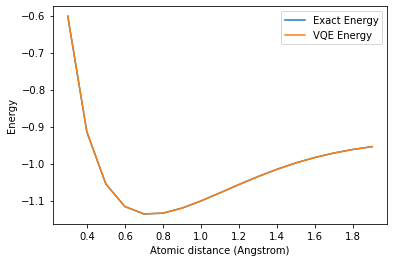

In [30]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()

In [60]:
np.sqrt(0.779**2 + 0.45**2)

0.8996338143933897

In [77]:
def get_qubit_op_h3():
    #      H
    #
    #   H      H
    # Define Molecule
    molecule = Molecule(
        # Coordinates in Angstrom
      
        geometry=[
            ["H", [0.0, 0.0, -2.246]],
            ["N", [0.0, 0.0, 0.0]],
            ["C", [0.0, 0, 1.179]]
        ],
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )

    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type=ElectronicStructureDriverType.PYSCF)

    # Get properties
    properties = driver.run()
    num_particles = (properties
                        .get_property("ParticleNumber")
                        .num_particles)
    num_spin_orbitals = int(properties
                            .get_property("ParticleNumber")
                            .num_spin_orbitals)

    # Define Problem, Use freeze core approximation, remove orbitals.
    problem = ElectronicStructureProblem(
        driver,
        [FreezeCoreTransformer(freeze_core=True, remove_orbitals= range(0, 2))])

    second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles
    #print(second_q_ops)
    # Get Hamiltonian
    mapper = ParityMapper()  # Set Mapper
    hamiltonian = second_q_ops[0]  # Set Hamiltonian
    # Do two qubit reduction
    converter = QubitConverter(mapper,two_qubit_reduction=True)
    reducer = TwoQubitReduction(num_particles)
    qubit_op = converter.convert(hamiltonian)
    qubit_op = reducer.convert(qubit_op)

    return qubit_op, num_particles, num_spin_orbitals, problem, converter

In [78]:
def exact_solver(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

backend = BasicAer.get_backend("statevector_simulator")
distances = np.arange(0.3, 2.0, 0.1)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=5)

# pylint: disable=undefined-loop-variable
#for dist in distances:
(qubit_op, num_particles, num_spin_orbitals,
                            problem, converter) = get_qubit_op_h3()
#print(problem)
result = exact_solver(problem,converter)
exact_energies.append(result.total_energies[0].real)
init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
var_form = UCCSD(converter,
                    num_particles,
                    num_spin_orbitals,
                    initial_state=init_state)
vqe = VQE(var_form, optimizer, quantum_instance=backend)
vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
vqe_result = problem.interpret(vqe_calc).total_energies[0].real
vqe_energies.append(vqe_result)
print(
        f"VQE Result: {vqe_result:.5f}",
        f"Exact Energy: {exact_energies[-1]:.5f}")

print("All energies have been calculated")

KeyboardInterrupt: 

In [2]:
# oxalic acid geometry
#       O
#       |
#       C - C - O - H
#       |   
#       O - H
# Bond lengths in Angstroms
# C-O bond length is 1.43 Angstroms 
# C-C bond length is 1.45 Angstroms
# O-H bond length is 0.96 Angstroms

# set the Molecule for Oxalic Acid
geometry = [('C', (0., 0., 0.)),
            ('O', (0., 0., 1.43)),
            ('O', (0., 0., -1.43)),
            ('C', (1.45, 0., 0.)),
            ('O', (2.48, 0., 0.)),
            ('H', (3.44, 0., 0.)),
            ('H', (0., 0.96, -1.43))]

basis = 'sto-3g'
multiplicity = 1
charge = 0

# set the Molecule for Oxalic Acid
molecule = Molecule(geometry, basis, multiplicity, charge)


In [9]:
# Define Molecule
molecule = Molecule(
    # Coordinates in Angstrom
    geometry=[
        ["Li", [0.0, 0.0, 0.0]],
        ["H", [0.7, 0.0, 0.0]]
    ],
    multiplicity=1,  # = 2*spin + 1
    charge=0,
)

driver = ElectronicStructureMoleculeDriver(
    molecule=molecule,
    basis="sto3g",
    driver_type=ElectronicStructureDriverType.PYSCF)

# Get properties
properties = driver.run()
num_particles = (properties
                    .get_property("ParticleNumber")
                    .num_particles)
num_spin_orbitals = int(properties
                        .get_property("ParticleNumber")
                        .num_spin_orbitals)

# Define Problem, Use freeze core approximation, remove orbitals.
problem = ElectronicStructureProblem(
    driver,
    [FreezeCoreTransformer(freeze_core=True,
                            remove_orbitals=[-3,-2])])

second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP

In [12]:
list(second_q_ops)

['ParticleNumber',
 'ElectronicEnergy',
 'DipoleMomentX',
 'DipoleMomentY',
 'DipoleMomentZ',
 'AngularMomentum',
 'Magnetization']

In [13]:
mapper